<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

# Title: Quantum simulation with hybrid tensor networks

## Introduction: 
This paper proposes a general framework denoting hybrid tensor networks, which is the combination of classical tensor networks and quantum tensor networks. More precisely, the paper summarizes the general strategy to contract indices between different types of tensors:

    1. classical tensor + quantum tensor, with classical indices
    2. classical tensor + quantum tensor, with classical indices + quantum indices 
    3. classical tensor + quantum tensor, with quantum indices
    4. quantum tensor + quantum tensor, with quantum indices + classical indices
    5. quantum tensor + quantum tensor, with quantum indices

These operations can be performed with a combination of classical tensor contraction and quantum circuit measurement. The combination of these operations provides great flexibility and expressiveness to the hybrid tensor networks. More precisely, one can use a tree-structured tensor network where each layer is represented by a quantum tensor (prepared by a quantum circuit). Thus, each building block is a large full-rank tensor and the tensor network is much more powerful after contraction than conventional low-rank proposals such as the MPS approach (where all building blocks are just small pieces due to the limitation of computational resources).

In this repetition, we show how to define a hybrid tensor network with two layers of quantum tensors (quantum circuit), which serves as the $|\Phi(\theta)>$ ansatz for VQE problem, and the optimization of the circuit parameters using the ansatz-based imaginary time evolution method.

In [ ]:
## 安装最新版Minduantum

!pip install https://hiq.huaweicloud.com/download/mindquantum/newest/linux/mindquantum-master-cp37-cp37m-linux_x86_64.whl -i https://pypi.tuna.tsinghua.edu.cn/simple

!pip show mindquantum

We first define our hybrid quantum tensor. In our experiment, we focus on the special case of a hybrid tensor tree consisting of two layers of quantum tensors connected by quantum indices. This hybrid tensor tree serves as an ansatz for our VQE target, which is prepared with a set of quantum circuits. In the following, we implement this idea using the QuantumTensor class.

![image](./circuit.png)

In [2]:
import numpy as np
import itertools
from mindquantum import Hamiltonian
from mindquantum.core.operators import QubitOperator

import mindquantum
from mindquantum import Circuit, RY, RX, RZ
from mindquantum import X, Z, Y
# from mindquantum.core.gates import X, Z#, ZZ
import numpy as np
from mindquantum.core import ParameterResolver
import math
from mindquantum import Simulator, Measure

class Parameter_manager:
    def __init__(self, key='default'):
        self.parameters = []
        self.count = 0
        self.key = key
        self.grad_key = None
    
    def random_parameter_resolver(self):
        pr = {k:np.random.randn()*2*math.pi for k in self.parameters}
        pr = ParameterResolver(pr)
        return pr

    def _replay(self):
        self.count = 0

    def set_grad_key(self, key):
        self.grad_key = key
        self._replay()    

    def create(self):
        param = '{}_theta_{}'.format(self.key, self.count)
        self.count += 1
        self.parameters.append(param)
        if self.grad_key is None or param!=self.grad_key:
            is_grad = False
        else:
            is_grad = True
        return param, is_grad



def RY_gate(circ, i, P):
    ry, is_grad = P.create()
    if not is_grad:
        circ += RY(ry).on(i)
    else:
        circ += Y.on(i)
        circ += RY(ry).on(i)

def RX_gate(circ, i, P):
    rx, is_grad = P.create()
    if not is_grad:
        circ += RX(rx).on(i)
    else:
        circ += X.on(i)
        circ += RX(rx).on(i)

def RZ_gate(circ, i, P):
    rz, is_grad = P.create()
    if not is_grad:
        circ += RZ(rz).on(i)
    else:
        circ += Z.on(i)
        circ += RZ(rz).on(i)

def RZZ_gate(circ, i, j, P):
    circ += X.on(j, i)
    RZ_gate(circ, j, P)
    circ += X.on(j, i)


def regular_block(C, n_qubits, P):
    for i in range(n_qubits):
        # C += RY(P.create()).on(i)
        RY_gate(C, i, P)
    for i in range(n_qubits-1):
        C += X.on(i, i+1)
        
def special_block_1(C, n_qubits, P):
    for i in range(n_qubits):
        # C += RX(P.create()).on(i)
        RX_gate(C, i, P)
    
def special_block_2(C, n_qubits, P):
    for i in range(n_qubits):
        RZ_gate(C, i, P)

    for i in range(n_qubits-1):
        RZZ_gate(C, i, i+1, P)
    


class QuantumTensor:
    def __init__(self):
        self.special_block = {
            'first': special_block_1,
            'second': special_block_2
        }
        self.depth = {
            'first': 6,
            'second': 8
        }
    
        
    def layer(self, P, n_qubits=8, layer_type='first'):
        special_block = self.special_block[layer_type]
        d = self.depth[layer_type]
        
        C = Circuit()
        for i in range(d):
            regular_block(C, n_qubits, P)
            if i==0 or i==d//2: #first and d/2+1'th layer
                special_block(C, n_qubits, P)

        return C
    
qt = QuantumTensor()
P = Parameter_manager()
qt.layer(P)


q0: ──RY(default_theta_0)────X────RX(default_theta_8)────RY(default_theta_16)─────────────────────────────────────X──────────────RY(default_theta_24)─────────────────────────────────────X──────────────RY(default_theta_32)─────────────────────────────────────X──────────────RX(default_theta_40)────RY(default_theta_48)─────────────────────────────────────X──────────────RY(default_theta_56)─────────────────────────────────────X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                             │                                                                                    │                                                                       │                                                                       │                                                                                               │                                                                       │
q1: ──RY(default_theta_1)────●─────────────X─────────────RX(default_theta_9)─────RY(default_theta_17)─────────────●───────────────────────X──────────────RY(default_theta_25)─────────────●───────────────────────X──────────────RY(default_theta_33)─────────────●───────────────────────X──────────────RX(default_theta_41)────RY(default_theta_49)─────────────●───────────────────────X──────────────RY(default_theta_57)─────────────●───────────────────────X──────────────────────────────────────────────────────────────────────────────────────────────
                                           │                                                                                              │                                                                       │                                                                       │                                                                                               │                                                                       │
q2: ──RY(default_theta_2)──────────────────●──────────────────────X──────────────RX(default_theta_10)────RY(default_theta_18)─────────────●───────────────────────X──────────────RY(default_theta_26)─────────────●───────────────────────X──────────────RY(default_theta_34)─────────────●───────────────────────X──────────────RX(default_theta_42)────RY(default_theta_50)─────────────●───────────────────────X──────────────RY(default_theta_58)─────────────●───────────────────────X──────────────────────────────────────────────────────────────────────
                                                                  │                                                                                               │                                                                       │                                                                       │                                                                                               │                                                                       │
q3: ──RY(default_theta_3)─────────────────────────────────────────●───────────────────────X──────────────RX(default_theta_11)────RY(default_theta_19)─────────────●───────────────────────X──────────────RY(default_theta_27)─────────────●───────────────────────X──────────────RY(default_theta_35)─────────────●───────────────────────X──────────────RX(default_theta_43)────RY(default_theta_51)─────────────●───────────────────────X──────────────RY(default_theta_59)─────────────●───────────────────────X──────────────────────────────────────────────
                                                                                          │                                                                                               │                                                                       │                                                                       │                                                                                               │                                 

Next, we define the Hamiltonian for each subsystem of n_qubits, i.e., the second layer of the tree structure presented in the paper. Following the paper, we add an additional qubit (the last one), which is the index that connects to the first layer, and this qubit is measured with the 4 Pauli operators 'I', 'X', 'Y', 'Z'. There is one additional remark I need to make: Since the quantum tensor contraction method proposed in this paper only supports the tensor product of local observables, we need to show that the expectation calculation can be done in the same way with respect to more general Hamiltonians. It turns out that this is the case since the expectation value $<\Phi|H|\Phi>$ is a linear functional with respect to $H$ and we can always decompose $H$ into a linear combination of Pauli strings, each of which is the tensor product of local observables (i.e., Pauli operators). Therefore, no special treatment is needed for the interaction between subsystems. It is sufficient to split the Hamiltonian into local Hamiltonians for each subsystem (set of qubits).

Note: The numerical experiment described in the paper uses case 4 (quantum tensor + quantum tensor, with quantum indices + classical indices) for the contraction. However, in this implementation we have used case 5 (quantum tensor + quantum tensor, with quantum indices) for the contraction. The side effect of this choice is that the resulting tensor network is no longer guaranteed to be normalized. We will show this in the experiments section using the optimization method of ansatz-based imaginary time evolution.

In [3]:

class Hamiltonian_1D:
    def __init__(self, n_qubits=8):
        self.n_qubits = n_qubits
    
    def local_Hamiltonian_with_pauli(self, f_first, f_last, pauli_type='X'):
        if pauli_type=='I':
            ham = self._local_Hamiltonian(f_first, f_last)
        else:
            ham = self._local_Hamiltonian_with_pauli(f_first, f_last, pauli_type)
        ham = Hamiltonian(ham)
        return ham
    
    def vac_Hamiltonian_with_pauli(self, pauli_type='X'):
        if pauli_type=='I':
            ham = QubitOperator('')
        else:
            ham = QubitOperator('{}{}'.format(pauli_type, self.n_qubits))
        ham = Hamiltonian(ham)
        return ham

    def _local_Hamiltonian(self, f_first, f_last):
        ham = None
        g, h = 0.5, 0.32
        for i in range(self.n_qubits):
            if ham is None:
                ham = QubitOperator('X{}'.format(i), g)
            else:
                ham += QubitOperator('X{}'.format(i), g)
                
            ham += QubitOperator('Z{}'.format(i), h)
            if i<self.n_qubits-1:
                ham += QubitOperator('Z{} Z{}'.format(i, i+1), 1)

        i, j = 0, self.n_qubits-1
        ham += QubitOperator('Z{}'.format(i), f_first)
        ham += QubitOperator('Z{}'.format(j), f_last)
        
        return ham

    
    def _local_Hamiltonian_with_pauli(self, f_first, f_last, pauli_type='X'):
        ham = None
        g, h = 0.5, 0.32
        for i in range(self.n_qubits):
            if ham is None:
                ham = QubitOperator('X{} {}{}'.format(i, pauli_type, self.n_qubits), g)
            else:
                ham += QubitOperator('X{} {}{}'.format(i, pauli_type, self.n_qubits), g)
                
            ham += QubitOperator('Z{} {}{}'.format(i, pauli_type, self.n_qubits), h)
            if i<self.n_qubits-1:
                ham += QubitOperator('Z{} Z{} {}{}'.format(i, i+1, pauli_type, self.n_qubits), 1)
                
        i, j = 0, self.n_qubits-1
        ham += QubitOperator('Z{} {}{}'.format(i, pauli_type, self.n_qubits), f_first)
        ham += QubitOperator('Z{} {}{}'.format(j, pauli_type, self.n_qubits), f_last)
    
        return ham
    
    
H = Hamiltonian_1D(n_qubits=8)
L = H.local_Hamiltonian_with_pauli(0.12, 0.89)

Next, we define our operator component $M_{ij}$ for the first layer of the tensor tree using the expectation value obtained from measuring the quantum circuit of the second layer of the tensor tree.

In [4]:
from mindquantum import Simulator, Measure

f_i, f_j = np.random.rand(), np.random.rand()

def layer_operator_component(boundary_condition, n_qubits=8):
    qt = QuantumTensor()
    P = Parameter_manager()
    circ = qt.layer(P, n_qubits=n_qubits+1, layer_type='second')
    pr = P.random_parameter_resolver()
    H = Hamiltonian_1D(n_qubits=n_qubits)

    expectation = {}
    for pauli_key in ['I', 'X', 'Y', 'Z']:
        sim = Simulator('projectq', n_qubits+1)        
        sim.apply_circuit(circ, pr=pr)

        f_first, f_last = boundary_condition
        ham = H.local_Hamiltonian_with_pauli(f_first, f_last, pauli_key)

        E = sim.get_expectation(ham).real
        expectation[pauli_key] = E
            
    return expectation
        
layer_operator_component((f_i, f_j), n_qubits=8)

{'I': -0.016337062164902494,
 'X': -0.0291263097549221,
 'Y': 0.050951501161404344,
 'Z': 0.026190910733539255}

<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

The Hamiltonian for the first layer is the tensor product of operator component $\{M^0, M^1, ...\}$ defined above, where each $M^j$ represents one subsystems. 

$$\begin{aligned}
H &= {\bigotimes_{j=1}^N} M^j \\
&= {\bigotimes_{j=1}^N} \left(\sum_{i \in \{I, X, Y, Z\}} \alpha^j_i \sigma^j_i \right)
\end{aligned}
$$
$N$ is the number of qubits, $\sigma_i^j$ is the Pauli operator $i \in \{I, X, Y, Z\}$ on the $j$th qubit

To do this, we firstly need to implement a tensor product of multiple QubitOperators. Below, we define a helper class that does this. Note that by default QubitOperator supports the tensor product by overloading the operator `*`. The author of this notebook did not know this when he wrote this piece of code. This method will be improved with the `*` operator in a future version. 

In [5]:

class QubitOperator_helper:
    def __init__(self):
        self.coeff = {'I': 0.5, 'X': 0.5, 'Y': -0.5, 'Z': 0.5}
        self.verbose_dict = {0:{'I':1,'X':1,'Y':1,'Z':1}}

    def get_coeff(self):
        return self.coeff
    
    def initialize_single(self, ei, ex, ey, ez):
        self._dict = {'I': self.coeff['I']*ei, 'X': self.coeff['X']*ex, 'Y': self.coeff['Y']*ey, 'Z': self.coeff['Z']*ez }
        self.verbose_dict = {0:{'I':ei, 'X':ex, 'Y':ey, 'Z':ez}}
        
    def tensor_product(self, vqo):
        _dict = {}
        for ki, kj in itertools.product(self._dict.keys(), vqo._dict.keys()):
            k = ki+kj
            v = self._dict[ki]*vqo._dict[kj]
            _dict[k] = v
        self._dict = _dict

        assert len(vqo.verbose_dict)==1
        append_index = len(self.verbose_dict)
        self.verbose_dict[append_index] = vqo.verbose_dict[0]

        return self
    
    def to_QubitOperator(self):
        return self._to_QubitOperator(self._dict)
    
    def _to_QubitOperator(self, _dict):
        qo = None
        for k, v in _dict.items():
            S = ''
            for i, s in enumerate(k):
                if s!='I':
                    S += '{}{} '.format(s, i)
            
            if qo is None:
                qo = v * QubitOperator(S)
            else:
                qo += v * QubitOperator(S)
        return qo


To use this class, for example:

In [6]:
V1, V2 = QubitOperator_helper(), QubitOperator_helper()
V1.initialize_single(0.1, 0.35, 0.24, 0.55)
V2.initialize_single(0.33, 0.12, 0.45, 0.66)
V = V1.tensor_product(V2)
V.to_QubitOperator()

0.00825 [] +
0.028874999999999998 [X0] +
0.010499999999999999 [X0 X1] +
-0.039375 [X0 Y1] +
0.057749999999999996 [X0 Z1] +
-0.0198 [Y0] +
-0.0072 [Y0 X1] +
0.027 [Y0 Y1] +
-0.0396 [Y0 Z1] +
0.045375000000000006 [Z0] +
0.0165 [Z0 X1] +
-0.061875000000000006 [Z0 Y1] +
0.09075000000000001 [Z0 Z1] +
0.003 [X1] +
-0.011250000000000001 [Y1] +
0.0165 [Z1] 

After we have defined the ansatz circuit and the Hamiltonian, we can contract the hybrid tensor network, i.e., determine the expectation energy. To do this, we first contract the second layer with the function `layer_operator_component` and then create the operator for the first layer with `QubitOperator_helper`:

In [7]:
n_subsystems = 3
n_qubits_per_subsystems = 8

#we pad 0 around random array to indicate both end of the systems are free of interaction
interaction_coeff = [0, ] + np.random.rand(n_subsystems-1).tolist() + [0, ]
boundary_pairs = []
for i in range(len(interaction_coeff)-1):
    boundary_pairs.append([interaction_coeff[i], interaction_coeff[i+1]])

    
def layer1_operator(boundary_pairs, n_subsystems=3, n_qubits_per_subsystems=8):
    V = None
    for i in range(n_subsystems):
        pair = boundary_pairs[i]
        expectation = layer_operator_component(pair, n_qubits=n_qubits_per_subsystems)

        nv = QubitOperator_helper()
        nv.initialize_single(*[expectation[x] for x in ['I', 'X', 'Y', 'Z']])
        if V is None:
            V = nv
        else:
            V = V.tensor_product(nv)
    return V.to_QubitOperator()
    
layer1_operator(boundary_pairs, n_subsystems=n_subsystems, n_qubits_per_subsystems=n_qubits_per_subsystems)

-0.0002126847252403117 [] +
-7.58560150444625e-05 [X0] +
8.557613068092514e-05 [X0 X1] +
6.24770733541745e-05 [X0 X1 X2] +
0.00015773027366311788 [X0 X1 Y2] +
-3.186767341277732e-05 [X0 X1 Z2] +
4.027990518017392e-05 [X0 Y1] +
2.9407389310742245e-05 [X0 Y1 X2] +
7.424220301432056e-05 [X0 Y1 Y2] +
-1.4999823585918912e-05 [X0 Y1 Z2] +
-1.3172808094897985e-06 [X0 Z1] +
-9.617150145453478e-07 [X0 Z1 X2] +
-2.4279557970048797e-06 [X0 Z1 Y2] +
4.905418636682631e-07 [X0 Z1 Z2] +
-5.538065087283301e-05 [X0 X2] +
-0.00013981457115148116 [X0 Y2] +
2.8248002037447588e-05 [X0 Z2] +
-0.00017419392842191975 [Y0] +
0.0001965149681764904 [Y0 X1] +
0.00014347084852122844 [Y0 X1 X2] +
0.0003622080066338615 [Y0 X1 Y2] +
-7.318015872814669e-05 [Y0 X1 Z2] +
9.249780542366016e-05 [Y0 Y1] +
6.753042149219665e-05 [Y0 Y1 X2] +
0.0001704880092921025 [Y0 Y1 Y2] +
-3.4445234099569577e-05 [Y0 Y1 Z2] +
-3.0249719670264333e-06 [Y0 Z1] +
-2.208459227759384e-06 [Y0 Z1 X2] +
-5.5754992938549765e-06 [Y0 Z1 Y2] +
1.12646

Here comes the final step to calculate an expectation: expectation over the first layer using `get_expectation` function.

In [8]:
def layer1_expectation(boundary_pairs, n_subsystems=3, n_qubits_per_subsystems=8):
    qt = QuantumTensor()
    P = Parameter_manager()
    circ = qt.layer(P, n_qubits=n_subsystems, layer_type='first')
    qo = layer1_operator(boundary_pairs, n_subsystems=n_subsystems, n_qubits_per_subsystems=n_qubits_per_subsystems)
    qo = qo.real #convert QubitOperator to its real part, since it is constructed using previous measure, there exist small imaginary part, due to numerical issue.
    ham = Hamiltonian(qo)
    sim = Simulator('projectq', n_subsystems)
    pr = P.random_parameter_resolver()
    
    sim.apply_circuit(circ, pr=pr)
    E = sim.get_expectation(ham)
    return E

layer1_expectation(boundary_pairs)


(0.0011301819337112152-8.131516293641283e-20j)

So far, we have implemented the hybrid tensor network circuit, the 1D Hamiltonian of the ising-like model, and the expectation calculation (decomposed into hierarchical quantum circuit measurement). Recall that our quantum circuit is initialized with random parameters and our goal for VQE is to compute the parameter that optimizes the expectation value. To better manage all the parameters, we combine all the above parts into one class.

In [14]:
class VQE_1D:
    def __init__(self, n_subsystems=3, n_qubits_per_subsystems=8):
        self.interaction_coeff = np.random.rand(n_subsystems-1).tolist()
        #we pad 0 around random array to indicate both end of the systems are free of interaction
        interaction_coeff = [0, ] + self.interaction_coeff + [0, ]
        self.boundary_pairs = []
        for i in range(len(interaction_coeff)-1):
            self.boundary_pairs.append([interaction_coeff[i], interaction_coeff[i+1]])
            
        self.n_subsystems = n_subsystems
        self.n_qubits_per_subsystems = n_qubits_per_subsystems

        self.qt = QuantumTensor()
        ''' layer1 construction'''
        P = Parameter_manager(key='layer1')
        self.layer1_circ = self.qt.layer(P, n_qubits=n_subsystems, layer_type='first')
        self.layer1_pr = P.random_parameter_resolver()
        
        
        ''' layer2 construction'''
        self.subsystem_dict = {}
        self.subsystem_P = {}
        for i in range(n_subsystems):
            P = Parameter_manager(key='layer2_{}'.format(i))
            circ = self.qt.layer(P, n_qubits=n_qubits_per_subsystems+1, layer_type='second')
            pr = P.random_parameter_resolver()

            self.subsystem_dict[i] = (circ, pr, n_qubits_per_subsystems+1)

    def norm(self):
        # layer1_operator is resulted from measurement of layer2
        qo = self.vac_layer1_operator().to_QubitOperator()
        qo = qo.real #convert QubitOperator to its real part, since it is constructed using previous measure, there exist small imaginary part, due to numerical issue.
        ham = Hamiltonian(qo)
        sim = Simulator('projectq', self.n_subsystems)
        sim.apply_circuit(self.layer1_circ, pr=self.layer1_pr)

        E = sim.get_expectation(ham)
        return E        


    def layer1_expectation(self):
        # layer1_operator is resulted from measurement of layer2
        qo = self.layer1_operator().to_QubitOperator()
        qo = qo.real #convert QubitOperator to its real part, since it is constructed using previous measure, there exist small imaginary part, due to numerical issue.
        ham = Hamiltonian(qo)
        sim = Simulator('projectq', self.n_subsystems)
        sim.apply_circuit(self.layer1_circ, pr=self.layer1_pr)

        # qs = sim.get_qs()
        # norm = qs.dot(np.conj(qs))
        # print('norm', norm)

        E = sim.get_expectation(ham)
        return E
            
    def layer1_operator(self):
        n_subsystems = self.n_subsystems
        V = None
        for i in range(n_subsystems):

            expectation = self.layer_operator_component(i)
            # print(expectation)

            nv = QubitOperator_helper()
            nv.initialize_single(*[expectation[x] for x in ['I', 'X', 'Y', 'Z']])
            if V is None:
                V = nv
            else:
                V = V.tensor_product(nv)
        return V
            
    
    def layer_operator_component(self, subsystem_index):
        circ, pr, n_qubits = self.subsystem_dict[subsystem_index]
        boundary_condition = self.boundary_pairs[subsystem_index]

        H = Hamiltonian_1D(n_qubits=n_qubits-1)

        expectation = {}
        for pauli_key in ['I', 'X', 'Y', 'Z']:
            sim = Simulator('projectq', n_qubits)        
            sim.apply_circuit(circ, pr=pr)

            f_first, f_last = boundary_condition
            ham = H.local_Hamiltonian_with_pauli(f_first, f_last, pauli_key)

            E = sim.get_expectation(ham).real
            expectation[pauli_key] = E
            
        return expectation


    def vac_layer1_operator(self):
        n_subsystems = self.n_subsystems
        V = None
        for i in range(n_subsystems):

            expectation = self.vac_layer_operator_component(i)

            nv = QubitOperator_helper()
            nv.initialize_single(*[expectation[x] for x in ['I', 'X', 'Y', 'Z']])
            if V is None:
                V = nv
            else:
                V = V.tensor_product(nv)
        return V


    def vac_layer_operator_component(self, subsystem_index):
        circ, pr, n_qubits = self.subsystem_dict[subsystem_index]
        # n_qubits = self.n_qubits_per_subsystems
        H = Hamiltonian_1D(n_qubits=n_qubits-1)

        expectation = {}
        for pauli_key in ['I', 'X', 'Y', 'Z']:
            sim = Simulator('projectq', n_qubits)        
            sim.apply_circuit(circ, pr=pr)

            ham = H.vac_Hamiltonian_with_pauli(pauli_type=pauli_key)

            E = sim.get_expectation(ham).real
            expectation[pauli_key] = E
            
        return expectation

    
V = VQE_1D()
for _ in range(3):
    E = V.layer1_expectation()
    norm = V.norm()
    print(E, norm)

(-0.0008306637088841629+1.0842021724855044e-19j) (0.13607070265698645+1.4094628242311558e-17j)
(-0.0008306637088841629+1.0842021724855044e-19j) (0.13607070265698645+1.4094628242311558e-17j)
(-0.0008306637088841629+1.0842021724855044e-19j) (0.13607070265698645+1.4094628242311558e-17j)


<script
  src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"
  type="text/javascript">
</script>

So far, we have successfully calculated the energy expectation of $<\Phi(\theta)|H|\Phi(\theta)>$ given randomly initialized circuit parameters. Next we need to optimize it. Note that although each layer of the hybrid tensor network is unitary, the overall network does not guarantee to be. The optimization problem with regard to the normalized term $\frac{<\Phi(\theta)|H|\Phi(\theta)>}{<\Phi(\theta)|\Phi(\theta)>}$ calls the technique of lagrange multiplier. However, in this paper, a better optimization technique which also solve such normalization problem is used: the ansatz-based imaginary time evolution method. For more details of this method, please check the paper recurrence #50. In this recurrence, I will only demonstrate how to calculate the gradients in a hybrid tensor network.

In mindquantum framework, all the gradients of expectation value $<\Phi(\theta)|H|\Phi(\theta)>$ with respect to circuit parameters $\theta$ can be easily obtained using `get_expectation_with_grad` function. However, there is one type of gradients we need to calculate by hand in oder to build the full chain of backpropogation. That is, the gradient with repect to parameters in Hamiltonian:
$$
\frac{\partial <\Phi(\theta)|H_{\alpha}|\Phi(\theta)>}{\partial \alpha_i^j}
$$
Where
$$\begin{aligned}
H_{\alpha} &= \left(\sum_{i \in \{I, X, Y, Z\}} \alpha^0_i \sigma^0_i \right) \otimes \left(\sum_{i \in \{I, X, Y, Z\}} \alpha^1_i \sigma^1_i \right)\otimes ... \\
&= {\bigotimes_{j=1}^M} \left(\sum_{i \in \{I, X, Y, Z\}} \alpha^j_i \sigma^j_i \right)
\end{aligned}
$$
$M$ is the number of qubits, $\sigma_i^j$ is the Pauli operator $i \in \{I, X, Y, Z\}$ on the $j$th qubit.

$\theta$ is the parameters on the ansatz circuit, for the gradient above, we just view it as constant coefficients.

Fortunately, this could be easily handled. Since the expectation $<\Phi(\theta)|H|\Phi(\theta)>$ is a linear functional with respect to $H$, we can aways decompose the expectation with linear combination of expectations over Pauli strings, and the gradient with respect to the coefficient of each Pauli string is just the expectation value of that Pauli string itself.

For example, considering the gradient with respect to $\alpha^0_X$, we can write:
$$\begin{aligned}
\frac{\partial <\Phi(\theta)|H_{\alpha}|\Phi(\theta)>}{\partial \alpha_0^X} &= \frac{  \partial  \alpha_0^X \left<\Phi(\theta)\left|\sigma^0_X \otimes {\bigotimes_{j=2}^M}\left(\sum_{i \in \{I, X, Y, Z\}} \alpha^j_i \sigma^j_i \right)\right|\Phi(\theta)\right>}{\partial \alpha_0^X} \\
&= \left<\Phi(\theta)\left|\sigma^0_X \otimes {\bigotimes_{j=2}^M}\left(\sum_{i \in \{I, X, Y, Z\}} \alpha^j_i \sigma^j_i \right)\right|\Phi(\theta)\right>
\end{aligned}
$$

To implement the above idea, we rewrite our QubitOperator_helper class:

In [15]:
class QubitOperator_helper:
    def __init__(self):
        self.coeff = {'I': 0.5, 'X': 0.5, 'Y': -0.5, 'Z': 0.5}
        self.verbose_dict = {0:{'I':1,'X':1,'Y':1,'Z':1}}

    def get_coeff(self):
        return self.coeff
    
    def initialize_single(self, ei, ex, ey, ez):
        self._dict = {'I': self.coeff['I']*ei, 'X': self.coeff['X']*ex, 'Y': self.coeff['Y']*ey, 'Z': self.coeff['Z']*ez }
        self.verbose_dict = {0:{'I':ei, 'X':ex, 'Y':ey, 'Z':ez}}
        
    def tensor_product(self, vqo):
        _dict = {}
        for ki, kj in itertools.product(self._dict.keys(), vqo._dict.keys()):
            k = ki+kj
            v = self._dict[ki]*vqo._dict[kj]
            _dict[k] = v
        self._dict = _dict

        assert len(vqo.verbose_dict)==1
        append_index = len(self.verbose_dict)
        self.verbose_dict[append_index] = vqo.verbose_dict[0]

        return self
    
    
    def gradient(self, qubit_index, key='I'):
        _dict = {}
        for k in self._dict.keys():
            if k[qubit_index]==key:
                # we need to / self.verbose_dict[qubit_index][key] because we do not want \alpha to appear
                _dict[k] = self._dict[k] / self.verbose_dict[qubit_index][key]

        return self._to_QubitOperator(_dict)
    
    
    def to_QubitOperator(self):
        return self._to_QubitOperator(self._dict)
    
    def _to_QubitOperator(self, _dict):
        qo = None
        for k, v in _dict.items():
            S = ''
            for i, s in enumerate(k):
                if s!='I':
                    S += '{}{} '.format(s, i)
            
            if qo is None:
                qo = v * QubitOperator(S)
            else:
                qo += v * QubitOperator(S)
        return qo

We are ready to implement our optimizer. We directly use the ansatz- based imaginary evolution method built in paper recursion #50. Note that in #50 we left an interface for passing root_gradient through the backpropogation chain, which works perfectly in this case. For convinience, we copy the package aITE of #50 in the src directory, and we can directly import it here.  

In [24]:
from src.aITE.optimizer import Optimizer
class OPT_VQE1D(VQE_1D):
    def __init__(self, n_subsystems=3, n_qubits_per_subsystems=8, lr=0.1, opt_type='aite'):
        super().__init__(n_subsystems=n_subsystems, n_qubits_per_subsystems=n_qubits_per_subsystems)
        self.layer1_optimizer = Optimizer(self.layer1_circ, self.layer1_pr, n_subsystems, opt_type=opt_type, lr=lr)
        
        self.layer2_optimizer = {}
        for i in range(self.n_subsystems):
            circ, pr, n_qubits = self.subsystem_dict[i]
            self.layer2_optimizer[i] = Optimizer(circ, pr, n_qubits, opt_type=opt_type, lr=lr)
    
        self.layer1_gradient = {}


    def clear_layer1_gradient(self):
        self.layer1_gradient = {}

    def update_layer1_gradient(self, qubit_index, pauli_key):
        n_subsystems = self.n_subsystems

        qo = self.layer1_gradient_operator(qubit_index, key=pauli_key)
        qo = qo.real #convert QubitOperator to its real part, since it is constructed using previous measure, there exist small imaginary part, due to numerical issue.
        ham = Hamiltonian(qo)
        
        # get expectation with respect to gradient operator will give us gradient we need
        sim = Simulator('projectq', n_subsystems)
        sim.apply_circuit(self.layer1_circ, pr=self.layer1_pr)
        E = sim.get_expectation(ham)
        
        self.layer1_gradient[(qubit_index, pauli_key)] = E #* QubitOperator_helper().get_coeff()[pauli_key]


    def layer1_gradient_operator(self, qubit_index, key='I'):
        # layer1_operator is resulted from measurement of layer2
        V = self.layer1_operator()
        qo = V.gradient(qubit_index, key=key)
        return qo


    def layer_operator_component_optimization(self, subsystem_index):
        r'''
        gradient down to the second layer
        '''
        circ, pr, n_qubits = self.subsystem_dict[subsystem_index]
        optimizer = self.layer2_optimizer[subsystem_index]

        boundary_condition = self.boundary_pairs[subsystem_index]
        H = Hamiltonian_1D(n_qubits=self.n_qubits_per_subsystems)

        f_first, f_last = boundary_condition

        for pauli_key in ['I', 'X', 'Y', 'Z']:
            # root_gradient for the backpropogation
            root_gradient = self.layer1_gradient[(subsystem_index, pauli_key)]

            ham = H.local_Hamiltonian_with_pauli(f_first, f_last, pauli_key)
            optimizer.step(ham, root_gradient=root_gradient)


        pr = optimizer.pr

        self.subsystem_dict[subsystem_index] = (circ, pr, n_qubits)
        self.layer2_optimizer[subsystem_index] = optimizer
    
    
    def step4layer2circuit(self):
        self.clear_layer1_gradient()
        
        for qubit_index in range(self.n_subsystems):
            for pauli_key in ['I', 'X', 'Y', 'Z']:
                self.update_layer1_gradient(qubit_index, pauli_key)
        for subsystem_index in range(self.n_subsystems):
            self.layer_operator_component_optimization(subsystem_index)
    

    def get_pr(self):
        _dict = {}
        for key in self.subsystem_dict.keys():
            _, pr = self.subsystem_dict[key]
            _dict[key] = pr
        return self.layer1_pr, _dict

    def step4layer1circuit(self):

        qo = self.layer1_operator().to_QubitOperator()
        qo = qo.real #convert QubitOperator to its real part, since it is constructed using previous measure, there exist small imaginary part, due to numerical issue.
        ham = Hamiltonian(qo)
        self.layer1_optimizer.step(ham)
        self.layer1_pr = self.layer1_optimizer.pr

n_subsystems=2
n_qubits_per_subsystems=3
m = OPT_VQE1D(n_subsystems=n_subsystems, n_qubits_per_subsystems=n_qubits_per_subsystems, lr=0.05)

for i in range(5):
    m.step4layer1circuit()
    m.step4layer2circuit()
        
    E = m.layer1_expectation()
    norm = m.norm()
    print(E.real, norm.real, (E/norm).real)

0.055987497839873814 0.20147283032561894 0.2778910573171937
0.022449032867529993 0.19967834950334404 0.11242597368902048
-0.003550320820126492 0.19853786854803773 -0.017882335728145814
-0.027090751823691497 0.19795845747230095 -0.136850691653233
-0.051428617625992275 0.19770974852032713 -0.26012180993040285


We can see that our method really improves the energy expectation! 

Now comes the experiment!

Following the paper, for 1D case, we use MPS with DMRG optimization method as benchmark. We use third-party package quimb to impement this classical method. Note that since our code only works under the develop version of quimb, we need to install the package from source file. To aviod polluting the mindquantum package, we build quimb outside of mindquantum folder.

In [17]:
!pwd

/home/ma-user/work/mindquantum/paper_recurrence/24_hw_008613816232674_01


In [ ]:
!cd ../../../ && git clone https://github.com/jcmgray/quimb.git

# check if it is develop branch(by default it should be)
!cd ../../../quimb && git branch

In [ ]:
!cd ../../../quimb && pip install .

import quimb
print(quimb.__version__)

!pip install opt_einsum

!pip install autoray

In [25]:
from src.benchmark.mps import MPS

M = MPS(n_subsystems=2, n_qubits_per_subsystems=3, bond_dim=32, interaction_coeff=m.interaction_coeff)
M.run()

SWEEP-1, direction=R, max_bond=(32/32), cutoff:1e-10


100%|############################################| 5/5 [00:00<00:00, 304.66it/s]

Energy: -1.892432917286383 ... not converged.
SWEEP-2, direction=R, max_bond=(6/32), cutoff:1e-10



100%|############################################| 5/5 [00:00<00:00, 316.94it/s]

Energy: -1.8924329173466905 ... converged!


In [26]:
value_list, norm_list, normalized_value_list = [], [], [] 
for i in range(20):
    m.step4layer1circuit()
    m.step4layer2circuit()
        
    E = m.layer1_expectation()
    norm = m.norm()
    if i%2==0:
        print(E.real, norm.real, (E/norm).real)
    value_list.append(E.real)
    norm_list.append(norm.real)
    normalized_value_list.append((E/norm).real)

-0.07941875818398607 0.19791427913550869 -0.40127856631107117
-0.16440970070611996 0.20034591229353732 -0.8206291749303808
-0.3672846754991099 0.21324702481792246 -1.722343727011948
-1.19625402928451 0.27954140366315827 -4.279344718201286
-6.633849958694438 0.6699429107664393 -9.902112332385263
-9.920525248084047 0.8277537866645489 -11.984874497595486
-12.800464348805798 0.9628882795988506 -13.293820913614825
-13.753107380981422 0.9969612160384428 -13.795027489265042
-13.779199062544397 0.9973012612446269 -13.816486149178258
-13.755964240000504 0.9959222764315271 -13.812286927941079


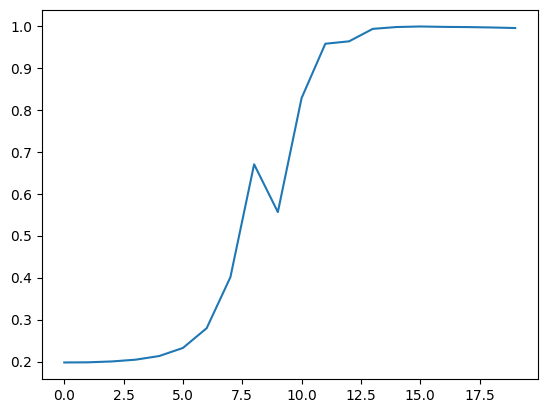

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(len(norm_list)), norm_list)
plt.show()
plt.close(fig)

One of the advantage of imaginary time evolution is that, along the evolution steps, the resulting state will become more and more normalized. We can see this fact from the plot above.

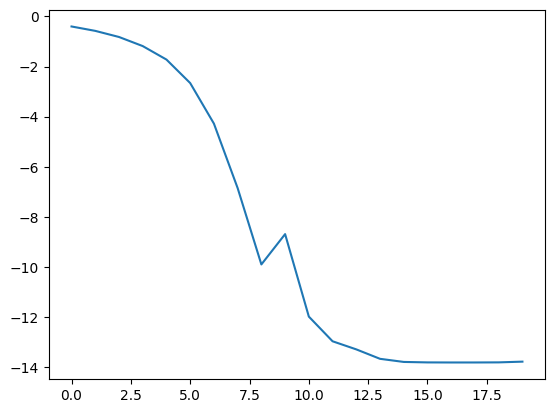

In [28]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(np.arange(len(normalized_value_list)), normalized_value_list)
plt.show()
plt.close(fig)

Issue: DMRG optimization on MPS ansatz converge to a much higher energy than our proposed hybrid quantum tensor method. What happened!??


## Summary

We implemented the hybrid quantum tree tensor network (HQTTN) ansatz proposed in the paper and tried ansatz-based imaginary time evolution for the VQE problem with an ising-like Hamiltonian. Instead of using case 4 (quantum tensor + quantum tensor, with quantum indices + classical indices) for the contraction, as described in the numerical experiments section of the paper, we used case 5 (quantum tensor + quantum tensor, with quantum indices) for the contraction. The side effect of this choice is that the resulting tensor network is no longer guaranteed to be normalized. This was confirmed in our experiment.

There are still problems in matching our optimization result with the tensor network based MPS approach with the DMRG optimization method. We will solve these problems in the future versions.